<a href="https://colab.research.google.com/github/ProtossDragoon/paper_implementation_and_testing_tf2/blob/main/notebooks/sm_unet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet test with SM & albumentations

## Paper

https://arxiv.org/pdf/1505.04597.pdf

## Author

name : Janghoo Lee <br>
github : https://github.com/ProtossDragoon <br>
contact : dlwkdgn1@naver.com <br>
circle : https://github.com/sju-coml <br>
organization : https://web.deering.co/ <br>
published date : May, 2021

## ThridParty

- github : https://github.com/qubvel/segmentation_models <br>
- github : https://github.com/albumentations-team/albumentations

# Environment

## Import

In [95]:
import tensorflow as tf
print(tf.__version__)
!pip install tensorboard
!pip install tensorboard-plugin-profile
%load_ext tensorboard

2.5.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [96]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
import math
from tqdm.notebook import tqdm as tqdm

## Show HW Spec and Setup HW

In [97]:
USE_TFCLOUD = False

### COLAB CPU

In [98]:
!cat /proc/cpuinfo
TRAINING_PARALLEL_STRATEGY = None

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

### [Choice] COLAB GPU

In [99]:
!nvidia-smi -L
TRAINING_PARALLEL_STRATEGY = None
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('total {} GPU devices: {}'.format(len(tf.config.list_logical_devices('GPU')), tf.config.list_logical_devices('GPU')))

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5cacf7a0-6934-83c1-d71b-b3d12d48233b)
total 1 GPU devices: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


### [Choice] COLAB TPU Setup

In [ ]:
assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU.'

# raise NotImplementedError
# 1. tf.keras model.Model subclassing API is unstable for TPU.
# 2. TPU training required GCP and GCS bucket.
# 3. TPU training input pipeline does not support tf.keras data loader, tf.data + TFRecord instead.

if 'COLAB_TPU_ADDER' in os.environ:
    tf_master = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
    tf_master = ''

TPU_ADDRESS = tf_master

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver) # initialize the tpu
TRAINING_PARALLEL_STRATEGY = tf.distribute.TPUStrategy(resolver) # Choose distribution strategy for parallel processing.
print('total {} of TPU devices: {}'.format(len(tf.config.list_logical_devices('TPU')), tf.config.list_logical_devices('TPU')))

### HW usage monitoring tool

In [6]:
%cd /content/
!pip install wandb -q
import wandb
wandb.init()
# clik link below

/content
     |████████████████████████████████| 1.8MB 8.6MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 174kB 51.2MB/s 
     |████████████████████████████████| 133kB 53.3MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Global Hyper Parameters

In [100]:
HOME_DIR = "/content/gdrive/MyDrive"
WS = os.path.join(HOME_DIR, "ColabWorkspace")
DATA_DIR = os.path.join(HOME_DIR, 'data')

GIT_REPO_NAME = 'paper_implementation_and_testing_tf2'
GIT_WS = os.path.join(WS, GIT_REPO_NAME)

GIT_REPO_THIRDPARTY_NAME = 'segmentation_models'
GIT_WS_THIRDPARTY = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME)
GIT_REPO_THIRDPARTY_NAME_2 = 'efficientnet'
GIT_WS_THIRDPARTY_2 = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME_2)
GIT_REPO_THIRDPARTY_NAME_3 = 'albumentations'
GIT_WS_THIRDPARTY_3 = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME_3)

LOG_DIR = os.path.join(GIT_WS, 'tboard')
MODEL_PLOT_DIR = os.path.join(GIT_WS, 'plotmodel')
WEIGHTS_DIR = os.path.join(GIT_WS, 'weights')
MODELS_DIR = os.path.join(GIT_WS, 'models')

In [101]:
GIT_BRANCH = 'unet'
GIT_USERNAME = None # Add here
GIT_EMAIL = None
GIT_PASSWORD = None # Add here

## Google Drive / Git

In [102]:
#!rm -r /content/gdrive/
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [103]:
!mkdir -p {WS}
%cd {WS}
!git clone https://github.com/ProtossDragoon/{GIT_REPO_NAME}.git
%cd {GIT_WS}
!git config --global user.name {GIT_USERNAME}
!git config --global user.email {GIT_EMAIL}
!git checkout -b {GIT_BRANCH}
!git checkout {GIT_BRANCH}
!git push origin {GIT_BRANCH}
!git branch --set-upstream-to origin/{GIT_BRANCH}

# !rm -r {GIT_WS_THIRDPARTY}
!git clone https://github.com/qubvel/{GIT_REPO_THIRDPARTY_NAME}.git
# !rm -r {GIT_WS_THIRDPARTY_2}
!git clone https://github.com/qubvel/{GIT_REPO_THIRDPARTY_NAME_2}.git
# !rm -r {GIT_WS_THIRDPARTY_a3}
!git clone https://github.com/qubvel/{GIT_REPO_THIRDPARTY_NAME_3}.git
!ls -al

!mkdir -p {LOG_DIR}
!mkdir -p {MODEL_PLOT_DIR}
!mkdir -p {WEIGHTS_DIR}
!mkdir -p {MODELS_DIR}

/content/gdrive/MyDrive/ColabWorkspace
fatal: destination path 'paper_implementation_and_testing_tf2' already exists and is not an empty directory.
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2
fatal: A branch named 'unet' already exists.
Already on 'unet'
fatal: could not read Username for 'https://github.com': No such device or address
error: the requested upstream branch 'origin/unet' does not exist
hint: 
hint: If you are planning on basing your work on an upstream
hint: branch that already exists at the remote, you may need to
hint: run "git fetch" to retrieve it.
hint: 
hint: If you are planning to push out a new local branch that
hint: will track its remote counterpart, you may want to use
hint: "git push -u" to set the upstream config as you push.
fatal: destination path 'segmentation_models' already exists and is not an empty directory.
fatal: destination path 'efficientnet' already exists and is not an empty directory.
fatal: destination path 'al

## Setup SM Lib

In [104]:
%cd {GIT_WS_THIRDPARTY}
%cd {GIT_WS_THIRDPARTY_2}
%set_env PYTHONPATH={'/env/python'+':'+GIT_WS_THIRDPARTY+':'+GIT_WS_THIRDPARTY_2} # way1
# 등록까지 약간의 시간이 소요됨. ModuleNotFoundError: No module named 'segmentation_models'
# 강제 등록
for path in [GIT_WS_THIRDPARTY, GIT_WS_THIRDPARTY_2]: #way2
    if path not in sys.path:
        sys.path.append(path)
print(sys.path)

/content/gdrive/MyDrive/ColabWorkspace/segmentation_models
/content/gdrive/MyDrive/ColabWorkspace/efficientnet
env: PYTHONPATH=/env/python:/content/gdrive/MyDrive/ColabWorkspace/segmentation_models:/content/gdrive/MyDrive/ColabWorkspace/efficientnet # way1
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/MyDrive/ColabWorkspace/segmentation_models', '/content/gdrive/MyDrive/ColabWorkspace/efficientnet', '/content/gdrive/MyDrive/ColabWorkspace/albumentations']


In [105]:
!pip install keras_applications>=1.0.7,<=1.0.8
!pip install image-classifiers==1.0.0
import segmentation_models as sm
sm.set_framework('tf.keras')

/bin/bash: =1.0.8: No such file or directory


## Setup albumentations

In [110]:
PYTHONPATH = !echo $PYTHONPATH
PYTHONPATH = PYTHONPATH[0].strip('[').strip(']')
print(PYTHONPATH)

/env/python:/content/gdrive/MyDrive/ColabWorkspace/segmentation_models:/content/gdrive/MyDrive/ColabWorkspace/efficientnet


In [111]:
# remove internal albumentations
!rm -r /usr/local/lib/python3.7/dist-packages/albumentations
!rm -r /usr/local/lib/python3.7/dist-packages/albumentations*
%set_env PYTHONPATH={PYTHONPATH+':'+GIT_WS_THIRDPARTY_3} #way1
for path in [GIT_WS_THIRDPARTY_3]: #way2
    if path not in sys.path:
        sys.path.append(path)
print(sys.path)

rm: cannot remove '/usr/local/lib/python3.7/dist-packages/albumentations': No such file or directory
rm: cannot remove '/usr/local/lib/python3.7/dist-packages/albumentations*': No such file or directory
env: PYTHONPATH=/env/python:/content/gdrive/MyDrive/ColabWorkspace/segmentation_models:/content/gdrive/MyDrive/ColabWorkspace/efficientnet:/content/gdrive/MyDrive/ColabWorkspace/albumentations #way1
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/MyDrive/ColabWorkspace/segmentation_models', '/content/gdrive/MyDrive/ColabWorkspace/efficientnet', '/content/gdrive/MyDrive/ColabWorkspace/albumentations']


In [112]:
import albumentations as A
print(A.__file__)

/content/gdrive/MyDrive/ColabWorkspace/albumentations/albumentations/__init__.py


## [Additional] GCP & TFCloud

Only run for GCP & TF-Cloud. Not for Vanilla google drive user.

### [Choice] Authenticate GCP User

If you use TPU, this cell must be run.

In [ ]:
# !pip install tensorflow_cloud # google colab already has tensorflow cloud
!pip install tensorflow_cloud -q
import tensorflow_cloud as tfc
print(tfc.__version__)
USE_TFCLOUD = True

GCP_BUCKET_NAME = 'deer-rudolph'
GCP_PROJECT_NAME = 'deer-deep-learning-project'
GCP_PROJECT_ID = 'linear-freehold-314804'
# REGION = 'us-central1'

if not tfc.remote():
    if "google.colab" in sys.modules:
        from google.colab import auth
        auth.authenticate_user()
        os.environ["GOOGLE_CLOUD_PROJECT"] = GCP_PROJECT_ID
# !gcloud config set project {GCP_PROJECT_ID}

### Global Hyper Parameters

Re-define hyper parameters we defined before.

In [ ]:
raise NotImplementedError

HOME_DIR = os.path.join('gs://', GCP_BUCKET_NAME)

HOME_DIR = "/content/gdrive/MyDrive"
WS = os.path.join(HOME_DIR, "ColabWorkspace")
DATA_DIR = os.path.join(HOME_DIR, 'data')


GIT_REPO_NAME = 'paper_implementation_and_testing_tf2'
GIT_WS = os.path.join(WS, GIT_REPO_NAME)

"""
GIT_REPO_THIRDPARTY_NAME = 'segmentation_models'
GIT_WS_THIRDPARTY = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME)
GIT_REPO_THIRDPARTY_NAME_2 = 'efficientnet'
GIT_WS_THIRDPARTY_2 = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME_2)
GIT_REPO_THIRDPARTY_NAME_3 = 'albumentations'
GIT_WS_THIRDPARTY_3 = os.path.join(WS, GIT_REPO_THIRDPARTY_NAME_3)
"""

LOG_DIR = os.path.join(GIT_WS, 'tboard')
MODEL_PLOT_DIR = os.path.join(GIT_WS, 'plotmodel')
WEIGHTS_DIR  = os.path.join(GIT_WS, 'weights')


You don’t need to worry about cloud-specific tasks such as creating VM instances and distribution strategies when using TensorFlow Cloud. The API includes intelligent defaults for all the parameters -- everything is configurable, but many models can rely on these defaults.

<br>

Upon calling run(), TensorFlow Cloud will:

- Make your Python script or notebook distribution-ready.
- Convert it into a Docker image with required dependencies.
- Run the training job on a GCP GPU-powered VM.
- Stream relevant logs and job information.
- The default VM configuration is 1 chief and 0 workers with 8 CPU cores and 1 Tesla T4 GPU.


reference : https://keras.io/guides/training_keras_models_on_cloud/

# Model

### UNet-ResNet

https://arxiv.org/abs/1512.03385

### UNet-EfficientNet

https://arxiv.org/abs/1905.11946

### UNet-Mobilenet

### UNet-Mobilenetv2

# Training

## TensorBoard

### [Caution] Clean Directory

In [ ]:
# Warning
"""
# clean all tboard directory
%cd {LOG_DIR}
!rm -r *
!ls
print('cleaned successfully!')
"""
# log driectory cleaned

"\n# clean all tboard directory\n%cd {LOG_DIR}\n!rm -r *\n!ls\nprint('cleaned successfully!')\n"

### Launch TensorBoard

In [ ]:
%tensorboard --logdir {LOG_DIR}
%reload_ext tensorboard

In [113]:
%tensorboard --logdir {LOG_DIR}

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 1189.

## Common

### Memory Size Calculator

In [296]:
def keras_model_memory_usage_in_bytes(model, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

### Dataset utils

#### Dataset Baseclass

In [501]:
# classes for data loading and preprocessing
import abc
class SegmentationDataset(abc.ABC):
    """Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
       Inheritance this class and implement fill_data method.
       - Inside of fill_data method, self.image_fps and self.mask_fps should be filled.
       - If you have RGB colorized masks, put {(int)classid: <tuple>(r,g,b)} shaped dictionary at self.train_id_to_rgb.
       
       Args:
            class_ids (list): values of classes ids       
            augmentation (albumentations.Compose): data transfromation pipeline 
                (e.g. flip, scale, etc.)
            preprocessing (albumentations.Compose): data preprocessing 
                (e.g. noralization, shape manipulation, etc.)
    """
    
    def __init__(self, class_ids=None, augmentation=None, preprocessing=None):

        # self.image_fps = user implementation 
        # self.masks_fps = user implementation        
        # self.train_id_to_rgb = user implementation
        self.class_ids = class_ids

        # flags
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        # mode
        self.mode = 'tf.keras.Sequence' # or tf.data.Dataset


    @abc.abstractmethod
    def fill_data(self):
        """Implement this mehtod and fill these member elements

        Member to elements:
            image_fps (str): file path to images
            masks_fps (str): file path to segmentation masks
        """
        pass


    def _readmask(self, i, train_id_to_rgb=None):
        """extract certain classes from mask (e.g. cars)
        """
        if train_id_to_rgb is None:
            mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
            masks = [(mask == v) for v in self.class_ids]
        else:
            self.interested_trainid_rgb = {}
            mask = cv2.imread(self.masks_fps[i])
            for k, v in self.train_id_to_rgb.items():
                if k in self.class_ids:
                    self.interested_trainid_rgb[k] = v
            masks = [(mask == rgb) for trainid, rgb in self.interested_trainid_rgb.items()]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        return mask

    
    def _readmask_tf(self, mask, train_id_to_rgb=None):
        if mask.shape[-1] == 1:
            mask = tf.squeeze(mask)
        if train_id_to_rgb is None:
            masks = [(mask == v) for v in self.class_ids]
        else:
            self.interested_trainid_rgb = {}
            for k, v in self.train_id_to_rgb.items():
                if k in self.class_ids:
                    self.interested_trainid_rgb[k] = v
            masks = [(mask == rgb) for trainid, rgb in self.interested_trainid_rgb.items()]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        return mask

    def _augmentation_tf(self, image, mask):
        ret = self.augmentation(image=image, mask=mask)
        image = ret['image']
        mask = ret['mask']
        print(image.dtype)
        print(mask.dtype)
        return image, mask


    def _preprocessing_tf(self, image, mask):
        ret = self.preprocessing(image=image, mask=mask)
        image = ret['image']
        mask = ret['mask']
        return image, mask


    def _getitem_keras(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        
        # extract certain classes from mask (e.g. cars)
        mask = self._readmask(i)
                
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask


    def _mapping_fn(self, images_fps, masks_fps):
        # images_fps : tf.Tensor, dtype string
        # masks_fps : tf.Tensor, dtype string

        print('Retracing!')
        image = tf.io.read_file(images_fps)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.uint8)

        mask = tf.io.read_file(masks_fps)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.uint8)
        mask = tf.py_function(func=self._readmask_tf, inp=[mask], Tout=tf.uint8)

        """
        if self._augmentation_exist:
            image, mask = tf.py_function(func=self._augmentation_tf, inp=[image, mask], Tout=[tf.float32, tf.uint8])

        if self._preprocessing_exist:
            image, mask = tf.py_function(func=self._preprocessing_tf, inp=[image, mask], Tout=[tf.float32, tf.uint8])
        """

        print(image)
        print(mask)

        return image, mask


    def get_tf_dataset(self):
        assert self.mode == 'tf.data.Dataset', 'Current mode : {}, If you want to use this method, implement self.images_dataset and self.masks_dataset'.format(self.mode)
        images_dataset = self.images_dataset
        masks_dataset = self.masks_dataset
        self._augmentation_exist = tf.constant(True if self.augmentation is not None else False, dtype=tf.bool, shape=())
        self._preprocessing_exist = tf.constant(True if self.preprocessing is not None else False, dtype=tf.bool, shape=())
        dataset = tf.data.Dataset.zip((images_dataset, masks_dataset)).map(self._mapping_fn)
        return dataset


    def __getitem__(self, i): # batch
        if self.mode == 'tf.keras.Sequence':
            return self._getitem_keras(i)
        else:
            print('tf.data.Dataset is not a subscribable object.')
            raise NotImplementedError


    def __len__(self):
        return len(self.images_fps)

#### [Default] Data Loader Baseclass (tf.keras.Sequence)

In [502]:
class DataLoader(tf.keras.utils.Sequence):

    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()


    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose tuple of lists (fixed)
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

#### [Extension] Data Loader fn (tf.data.Dataset)

In [503]:
def data_loader_tf(dataset_tf, batch_size, buffer_size=None):
    if buffer_size is None:
        buffer_size = batch_size * 2
    return dataset_tf.shuffle(buffer_size=buffer_size).repeat().batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Class Data Postprocess

In [504]:
class DataPostProcessTools:
    def __init__(self):
        pass
    
    @classmethod # helper function for data visualization
    def visualize(self, **images):
        """PLot images in one row."""
        n = len(images)
        plt.figure(figsize=(16, 5))
        for i, (name, image) in enumerate(images.items()):
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image)
        plt.show()

    @classmethod # helper function for data visualization
    def denormalize(self, x):
        """Scale image to range 0..1 for correct plot"""
        x_max = np.percentile(x, 98) # heuristic
        x_min = np.percentile(x, 2) # heuristic
        x = (x - x_min) / (x_max - x_min)
        x = x.clip(0, 1)
        return x

### Model Numeric Evaluation

In [505]:
def numeric_evaluation(model, preprocess_input):
    global TRAIN_BATCH_SIZE
    global XY_test
    global DATASET_WIDTH, DATASET_HEIGHT
    global MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, N_CLASSES
    global METRICS_SET


    print('Theoretical pure model size if batch size {}\t: {} byte'.format(TRAIN_BATCH_SIZE, keras_model_memory_usage_in_bytes(model, TRAIN_BATCH_SIZE)))
    print('Theoretical pure model size if batch size {}\t: {} byte'.format(1, keras_model_memory_usage_in_bytes(model, 1)))
    test_dataloader = DataLoader(XY_test, batch_size=1, shuffle=True)

    # ===
    # test with training data augmented technique 
    XY_test.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
    XY_test.augmentation   = get_training_augmentation(dataset_w=DATASET_WIDTH, 
                                                      dataset_h=DATASET_HEIGHT,
                                                      model_input_w_for_train=MODEL_INPUT_WIDTH_FOR_TRAIN,
                                                      model_input_h_for_train=MODEL_INPUT_HEIGHT_FOR_TRAIN,
                                                      rectangle=RECTANGLE)

    assert test_dataloader[0][0].shape == (1, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3)
    assert test_dataloader[0][1].shape == (1, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES) 
    scores = model.evaluate(test_dataloader)
    print('what - if your <prediction input> == <augmented image>')
    print('evaluate shape : (1,{},{},{})'.format(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3))
    for metric, value in zip(METRICS_SET, scores[1:]):
        print("mean {}: {:.5}".format(metric.name, value))
    visualize(XY_test)

    # ===
    # test with original dataset shape
    XY_test.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
    XY_test.augmentation   = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                        dataset_h=DATASET_HEIGHT,
                                                        model_input_w_for_valid=MODEL_INPUT_WIDTH_FOR_TRAIN,
                                                        model_input_h_for_valid=MODEL_INPUT_HEIGHT_FOR_TRAIN)

    assert test_dataloader[0][0].shape == (1, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3)
    assert test_dataloader[0][1].shape == (1, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES) 
    scores = model.evaluate(test_dataloader)
    print('what - if your <prediction input size> == <training input size>')
    print('evaluate shape : (1,{},{},{})'.format(MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3))
    for metric, value in zip(METRICS_SET, scores[1:]):
        print("mean {}: {:.5}".format(metric.name, value))
    visualize(XY_test)

    # ===
    # test with original model shape
    XY_test.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
    XY_test.augmentation   = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                        dataset_h=DATASET_HEIGHT,
                                                        model_input_w_for_valid=MODEL_INPUT_WIDTH_FOR_VALID,
                                                        model_input_h_for_valid=MODEL_INPUT_HEIGHT_FOR_VALID)

    assert test_dataloader[0][0].shape == (1, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3)
    assert test_dataloader[0][1].shape == (1, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, N_CLASSES) 
    scores = model.evaluate(test_dataloader)
    print('what - if your <prediction input size> == <validation input size>')
    print('evaluate shape : (1,{},{},{})'.format(MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3))
    for metric, value in zip(METRICS_SET, scores[1:]):
        print("mean {}: {:.5}".format(metric.name, value))
    visualize(XY_test)

## CamVid


For this example we will use CamVid dataset. It is a set of:
- **train** images + segmentation masks
- **validation** images + segmentation masks
- **test** images + segmentation masks
- All images have 320 pixels height and 480 pixels width.

<br>

For more inforamtion about dataset visit 
- http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf
- http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/

### Datasets

In [328]:
DATASET_DIR_CAMVID = os.path.join(DATA_DIR, 'camvid')
DATASET_TRAIN_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'train')
DATASET_TRAIN_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'trainannot')
DATASET_VAL_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'val')
DATASET_VAL_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'valannot')
DATASET_TEST_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'test')
DATASET_TEST_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'testannot')

%cd {WS}
%ls -al

/content/gdrive/MyDrive/ColabWorkspace
total 24
drwx------ 14 root root 4096 May 27 02:54 albumentations/
drwx------ 15 root root 4096 Jun 11 06:18 efficientnet/
drwx------  2 root root 4096 May 27 02:05 .ipynb_checkpoints/
drwx------ 13 root root 4096 May 25 05:07 paper_implementation_and_testing_tf2/
drwx------ 13 root root 4096 May 26 05:56 segmentation_models/
drwx------  2 root root 4096 Jun 10 05:47 {WEIGHTS_DIR}/


#### [Caution] Download Dataset

In [ ]:
%cd {WS}
!rm -r {DATASET_DIR_CAMVID}
!mkdir -p {DATASET_DIR_CAMVID}

%cd {DATASET_DIR_CAMVID}
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git . # This repository contains CamVid dataset.

print('\n')
%ls -al
!find . -maxdepth 1 ! -name 'CamVid' ! -name '.' -exec rm -r {} +
!mv ./CamVid/* .
!rm -d CamVid

print('\n')
%ls -al

/content/gdrive/MyDrive/ColabWorkspace
/content/gdrive/MyDrive/data/camvid
Cloning into '.'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Checking out files: 100% (1445/1445), done.


total 29
drwx------ 8 root root 4096 Jun  4 16:58 CamVid/
drwx------ 4 root root 4096 Jun  4 16:58 docker/
drwx------ 2 root root 4096 Jun  4 16:58 Example_Models/
drwx------ 8 root root 4096 Jun  4 16:58 .git/
-rw------- 1 root root   49 Jun  4 16:58 .gitattributes
-rw------- 1 root root   13 Jun  4 16:58 .gitignore
drwx------ 2 root root 4096 Jun  4 16:58 Models/
-rw------- 1 root root 3341 Jun  4 16:58 README.md
drwx------ 2 root root 4096 Jun  4 16:58 Scripts/


total 81
drwx------ 2 root root  4096 Jun  4 16:58 test/
drwx------ 2 root root  4096 Jun  4 16:58 testannot/
-rw------- 1 root root 19215 Jun  4 16:58 test.txt
drwx------ 2

### Hyper Parameters

In [475]:
# dataset and training info
DATASET_WIDTH = 480 #@param
DATASET_HEIGHT = 320 #@param
MODEL_INPUT_WIDTH_FOR_TRAIN = 320 #@param
MODEL_INPUT_HEIGHT_FOR_TRAIN = 320 #@param
RECTANGLE = MODEL_INPUT_WIDTH_FOR_TRAIN == MODEL_INPUT_HEIGHT_FOR_TRAIN 
MODEL_INPUT_WIDTH_FOR_VALID =  320+32*4#@param
MODEL_INPUT_HEIGHT_FOR_VALID =  320#@param

# model info
ARCHITECTURE = 'unet' #@param ['unet']
BACKBONE = 'efficientnetb7' #@param ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
preprocess_input = sm.get_preprocessing(BACKBONE)
DATASETNAME = 'camvid' #@param ['camvid']

if ARCHITECTURE == 'unet':
    assert MODEL_INPUT_WIDTH_FOR_TRAIN % 32 == 0, 'unet restricts input image width to multiple of 32.'
    assert MODEL_INPUT_HEIGHT_FOR_TRAIN % 32 == 0, 'unet restricts input image height to multiple of 32.'


# pipeline info
SAVE_WEIGHTS_ONLY = True
INPUT_PIPELINE = 'tf.keras.Sequence' #@param ['tf.keras.Sequence', 'tf.data']

# model hyper parameters
TRAIN_BATCH_SIZE = 8#@param
TRAIN_DATA_LEN = None
TRAIN_DATA_SHAPE = None
TRAIN_STEPS_PER_EPOCH = None
VALID_BATCH_SIZE =  8#@param
VALID_DATA_LEN = None
VALID_STEPS_PER_EPOCH = None
N_EPOCH =  50#@param
START_LR = 0.0001 #@param

NAME_INTERESTED_CLASSES = ['car', 'road', 'pavement', 'pedestrian', 'bicyclist'] #@param
N_CLASSES = 1 if len(NAME_INTERESTED_CLASSES) == 1 else (len(NAME_INTERESTED_CLASSES) + 1) # case for binary and multiclass segmentation

def _get_optimizer():
    global START_LR
    _OPTIM = tf.keras.optimizers.Adam(learning_rate=START_LR)
    return _OPTIM
    
def _get_dice_loss():
    global N_CLASSES
    _DICE_LOSS_WEIGHT = [1., 1., 1., 2., 3., 0.2]
    assert len(_DICE_LOSS_WEIGHT) == N_CLASSES
    _DICE_LOSS = sm.losses.DiceLoss(class_weights=np.array(_DICE_LOSS_WEIGHT)) # len(NAME_INTERESTED_CLASSES) + 1
    return _DICE_LOSS

def _get_focal_loss():
    global N_CLASSES
    _FOCAL_LOSS = sm.losses.BinaryFocalLoss() if N_CLASSES == 1 else sm.losses.CategoricalFocalLoss()
    return _FOCAL_LOSS

def _get_metric_iou():
    _IOU = sm.metrics.IOUScore(threshold=0.5)
    return _IOU

def _get_metric_FScore():
    _FScore = sm.metrics.FScore(threshold=0.5)
    return _FScore

def _get_metric_Accuracy():
    global N_CLASSES
    _Accuracy = tf.keras.metrics.BinaryAccuracy(name='binary_acc') if N_CLASSES == 1 else tf.keras.metrics.CategoricalAccuracy(name='categorical_acc')
    return _Accuracy

# Create the model, optimizer and metrics inside the strategy scope, so that the
# variables can be mirrored on each device.
if TRAINING_PARALLEL_STRATEGY is not None:
    with TRAINING_PARALLEL_STRATEGY.scope():
        LOSS_SET = [_get_dice_loss() + _get_focal_loss()]
        METRICS_SET = [_get_metric_iou(), _get_metric_FScore(), _get_metric_Accuracy()]
        OPTIMIZER = _get_optimizer()
else:
    LOSS_SET = [_get_dice_loss() + _get_focal_loss()]
    METRICS_SET = [_get_metric_iou(), _get_metric_FScore(), _get_metric_Accuracy()]
    OPTIMIZER = _get_optimizer()


MODEL_MEMO = 'b{}_{}c_{}_{}'.format(TRAIN_BATCH_SIZE, N_CLASSES, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN)
ADDITIONAL_MEMO = '' #@param {type:"string"}
MODEL_MEMO += ADDITIONAL_MEMO



#TODO
LOG_DIR_DATASETNAME = os.path.join(LOG_DIR, DATASETNAME.upper())
LOG_DIR_DATASETNAME_MODELINFO = os.path.join(LOG_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
WEIGHTS_DIR_DATASETNAME = os.path.join(WEIGHTS_DIR, DATASETNAME.upper())
WEIGHTS_DIR_DATASETNAME_MODELINFO = os.path.join(WEIGHTS_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
MODELS_DIR_DATASETNAME = os.path.join(MODELS_DIR, DATASETNAME.upper())
MODELS_DIR_DATASETNAME_MODELINFO = os.path.join(MODELS_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)

!mkdir -p {LOG_DIR_DATASETNAME_MODELINFO}
%cd {LOG_DIR_DATASETNAME}
%ls

!mkdir -p {WEIGHTS_DIR_DATASETNAME_MODELINFO}
%cd {WEIGHTS_DIR_DATASETNAME}
%ls

!mkdir -p {MODELS_DIR_DATASETNAMET_MODELINFO}
%cd {MODELS_DIR_DATASETNAME}
%ls

"""
# LEGACY

LOG_DIR_CAMVID = os.path.join(LOG_DIR, 'CAMVID')
LOG_DIR_CAMVID_UNET_RESNET34 = os.path.join(LOG_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)
LOG_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(LOG_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)

WEIGHTS_DIR_CAMVID = os.path.join(WEIGHTS_DIR, 'CAMVID')
WEIGHTS_DIR_CAMVID_UNET_RESNET34 = os.path.join(WEIGHTS_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)
WEIGHTS_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(WEIGHTS_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)

MODELS_DIR_CAMVID = os.path.join(MODELS_DIR, 'CAMVID')
MODELS_DIR_CAMVID_UNET_RESNET34 = os.path.join(MODELS_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)
MODELS_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(MODELS_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)

!mkdir -p {LOG_DIR_CAMVID_UNET_RESNET34}
!mkdir -p {LOG_DIR_CAMVID_UNET_EFFICIENTNETB3}

%cd {LOG_DIR_CAMVID}
%ls

!mkdir -p {WEIGHTS_DIR_CAMVID_UNET_RESNET34}
!mkdir -p {WEIGHTS_DIR_CAMVID_UNET_EFFICIENTNETB3}

%cd {WEIGHTS_DIR_CAMVID}
%ls

!mkdir -p {MODELS_DIR_CAMVID_UNET_RESNET34}
!mkdir -p {MODELS_DIR_CAMVID_UNET_EFFICIENTNETB3}

%cd {MODELS_DIR_CAMVID}
%ls
"""

/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/CAMVID
UNET_EFFICIENTNETB7/  UNET_MOBILENET/  UNET_MOBILENETV2/
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/weights/CAMVID
{MODELS_DIR_DATASETNAMET_MODELINFO}/  UNET_MOBILENET/
UNET_EFFICIENTNETB7/                  UNET_MOBILENETV2/
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/models/CAMVID
UNET_EFFICIENTNETB7/  UNET_MOBILENET/  UNET_MOBILENETV2/


"\n# LEGACY\n\nLOG_DIR_CAMVID = os.path.join(LOG_DIR, 'CAMVID')\nLOG_DIR_CAMVID_UNET_RESNET34 = os.path.join(LOG_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)\nLOG_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(LOG_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)\n\nWEIGHTS_DIR_CAMVID = os.path.join(WEIGHTS_DIR, 'CAMVID')\nWEIGHTS_DIR_CAMVID_UNET_RESNET34 = os.path.join(WEIGHTS_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)\nWEIGHTS_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(WEIGHTS_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)\n\nMODELS_DIR_CAMVID = os.path.join(MODELS_DIR, 'CAMVID')\nMODELS_DIR_CAMVID_UNET_RESNET34 = os.path.join(MODELS_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)\nMODELS_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(MODELS_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)\n\n!mkdir -p {LOG_DIR_CAMVID_UNET_RESNET34}\n!mkdir -p {LOG_DIR_CAMVID_UNET_EFFICIENTNETB3}\n\n%cd {LOG_DIR_CAMVID}\n%ls\n\n!mkdir -p {WEIGHTS_DIR_CAMVID_UNET_RESNET34}\n!mkdir -p {WEIGHTS_DIR_CAMVID_UNET_EFFICIENT

### Dataset Specific utils

#### [Default] Data Loader (tf.keras.Sequence)

- preprocessing
- augmentation

In [506]:
class CamVidDataset(SegmentationDataset):
    """CamVid Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        name_interested_classes (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
              'tree', 'signsymbol', 'fence', 'car', 
              'pedestrian', 'bicyclist', 'unlabelled']

    def fill_data(self, images_dir, masks_dir):
        # Fill data logic.
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids] # image file paths
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] # mask (label) file paths

    def __init__(self, images_dir, masks_dir, name_interested_classes=None, augmentation=None, preprocessing=None):
        # convert str names to class values on masks
        class_ids = [self.CLASSES.index(cls.lower()) for cls in name_interested_classes]

        super(CamVidDataset, self).__init__(class_ids=class_ids, augmentation=augmentation, preprocessing=preprocessing)
        self.fill_data(images_dir, masks_dir)

# Dataset for train images
XY_train = CamVidDataset(
    DATASET_TRAIN_X_DIR_CAMVID, 
    DATASET_TRAIN_Y_DIR_CAMVID, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

# Dataset for validation images
XY_valid = CamVidDataset(
    DATASET_VAL_X_DIR_CAMVID, 
    DATASET_VAL_Y_DIR_CAMVID, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

# Dataset for test images
XY_test = CamVidDataset(
    DATASET_TEST_X_DIR_CAMVID,
    DATASET_TEST_Y_DIR_CAMVID, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

#### [Extension] Data Loader (tf.data.Dataset)

In [507]:
class CamVidDatasetTF(CamVidDataset):
    """CamVid Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        name_interested_classes (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """

    def convert_filled_data(self):
        # convert data to tensorflow dataset format
        self.images_dataset = tf.data.Dataset.from_tensor_slices(self.images_fps)
        self.masks_dataset = tf.data.Dataset.from_tensor_slices(self.masks_fps)

    def __init__(self, *args, **kwargs):
        super(CamVidDatasetTF, self).__init__(*args, **kwargs)
        self.convert_filled_data()

# Dataset for train images
XY_train_tf = CamVidDatasetTF(
    DATASET_TRAIN_X_DIR_CAMVID, 
    DATASET_TRAIN_Y_DIR_CAMVID, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

# Dataset for validation images
XY_valid_tf = CamVidDatasetTF(
    DATASET_VAL_X_DIR_CAMVID, 
    DATASET_VAL_Y_DIR_CAMVID, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

# Dataset for test images
XY_test_tf = CamVidDatasetTF(
    DATASET_TEST_X_DIR_CAMVID,
    DATASET_TEST_Y_DIR_CAMVID, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

### Data Augmentation

In [508]:
def round_and_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

class RoundAndClipZeroOrOneOnMask(A.core.transforms_interface.DualTransform):
    def apply(self, img, **params): # target : img
        return img
    def apply_to_mask(self, img, **params): # target : mask
        return round_and_clip_0_1(img, **params) # mask value should be zero or one.

class PretrainedSpecificPreprocessing(A.core.transforms_interface.DualTransform):
    def __init__(self, fn):
        """
        Args:
            fn (callbale): data normalization function (can be specific for each pretrained neural network)
        """
        super().__init__(self)
        self.fn = fn
    def apply(self, img, **params): # target : img
        return self.fn(img)
    def apply_to_mask(self, img, **params): # target : mask
        return img

# define heavy augmentations
def get_training_augmentation(
    dataset_w=None, 
    dataset_h=None,
    model_input_w_for_train=None,
    model_input_h_for_train=None,
    rectangle=True
    ):
    assert dataset_w is not None
    assert dataset_h is not None
    assert model_input_w_for_train is not None
    assert model_input_h_for_train is not None

    shorter_side = dataset_w if dataset_w < dataset_h else dataset_h
    longer_side = dataset_w if dataset_w > dataset_h else dataset_h

    padding_percent = 10
    pad_h = int(model_input_h_for_train / 100 * padding_percent)
    pad_w = int(model_input_w_for_train / 100 * padding_percent)

    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=longer_side, min_width=longer_side, always_apply=True, border_mode=0) \
          if rectangle else A.PadIfNeeded(min_height=model_input_h_for_train+pad_h, min_width=model_input_w_for_train+pad_w, always_apply=True, border_mode=0),
        
        A.RandomCrop(height=model_input_h_for_train, width=model_input_w_for_train, always_apply=True) \
          if rectangle else A.RandomCrop(height=model_input_h_for_train, width=model_input_w_for_train, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        # A.Perspective(p=0.5, always_apply=True), # This method not support yet. (2021.05.28) try later.
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        RoundAndClipZeroOrOneOnMask()
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(
    dataset_w=None, 
    dataset_h=None,
    model_input_w_for_valid=None,
    model_input_h_for_valid=None
    ):
    assert dataset_w is not None
    assert dataset_h is not None
    #assert model_input_w_for_valid is not None
    #assert model_input_h_for_valid is not None

    """Add paddings to make image shape divisible by 32""" #FIXME
    test_transform = [
        A.PadIfNeeded(min_height=dataset_h, min_width=dataset_w)
    ]

    if (model_input_w_for_valid is not None) and (model_input_h_for_valid is not None):
        test_transform.append(
            A.RandomCrop(height=model_input_h_for_valid, 
                         width=model_input_w_for_valid, 
                         always_apply=True))
        #assert model_input_w_for_valid//32 == 0, 'For EfficientNet'
        #assert model_input_h_for_valid//32 == 0, 'For EfficientNet'
    else:
        pass
        #assert dataset_w//32 == 0, 'For EfficientNet'
        #assert dataset_h//32 == 0, 'For EfficientNet'
        
    return A.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        PretrainedSpecificPreprocessing(preprocessing_fn)
    ]
    return A.Compose(_transform)

### Define Prediction Visualization

In [491]:
def visualize(XY_test, n=3):
    n = n
    ids = np.random.choice(np.arange(len(XY_test)), size=n)
    for i in ids:
        image, gt_mask = XY_test[i]
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)
        DataPostProcessTools.visualize(
            image=DataPostProcessTools.denormalize(image.squeeze()),
            gt_mask=gt_mask.squeeze()[:,:,:3], #FIXME
            pr_mask=pr_mask.squeeze()[:,:,:3], #FIXME
        )

### EDA

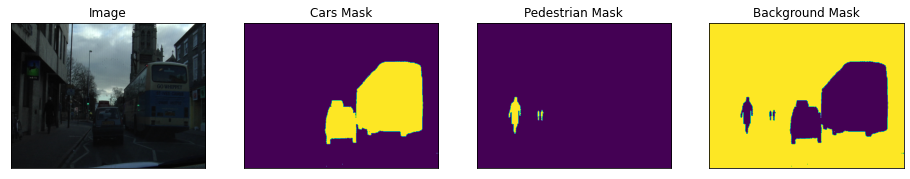

In [480]:
dataset_debug_eda = CamVidDataset(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                  name_interested_classes=['car', 'pedestrian'])
image, mask = dataset_debug_eda[5] # get some sample
DataPostProcessTools.visualize(
    image=image,
    cars_mask=mask[..., 0].squeeze(),
    pedestrian_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

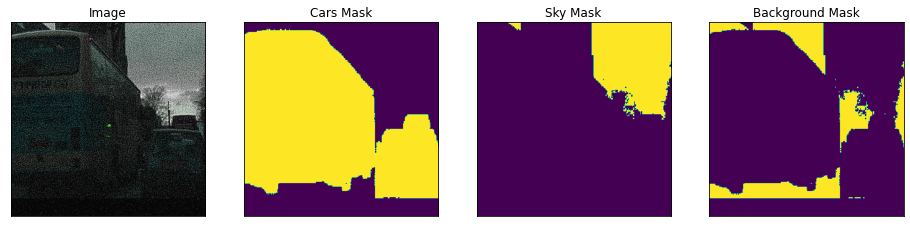

In [481]:
dataset_debug_aug = CamVidDataset(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                  name_interested_classes=['car', 'sky'], 
                                  augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, rectangle=RECTANGLE))
image, mask = dataset_debug_aug[5] # get some sample
DataPostProcessTools.visualize(
    image=image,
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),    
)

### Run UNet-BACKBONE

#### Train

In [33]:
!rm -r {LOG_DIR_DATASETNAME_MODELINFO} #select model
tf.keras.backend.clear_session()

XY_train.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
XY_train.augmentation   = get_training_augmentation(dataset_w=DATASET_WIDTH, 
                                                    dataset_h=DATASET_HEIGHT,
                                                    model_input_w_for_train=MODEL_INPUT_WIDTH_FOR_TRAIN,
                                                    model_input_h_for_train=MODEL_INPUT_HEIGHT_FOR_TRAIN,
                                                    rectangle=RECTANGLE)

XY_valid.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
XY_valid.augmentation   = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                      dataset_h=DATASET_HEIGHT,
                                                      model_input_w_for_valid=MODEL_INPUT_WIDTH_FOR_VALID,
                                                      model_input_h_for_valid=MODEL_INPUT_HEIGHT_FOR_VALID)

train_dataloader = DataLoader(XY_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
assert train_dataloader[0][0].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3)
assert train_dataloader[0][1].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES)
valid_dataloader = DataLoader(XY_valid, batch_size=VALID_BATCH_SIZE, shuffle=True)
assert valid_dataloader[0][0].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3)
assert valid_dataloader[0][1].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, N_CLASSES)

if TRAINING_PARALLEL_STRATEGY is None: 
    #tf.summary function unstable. Do not use this function when you run on TPU
    #later, wrap with @tf.function instead. See tf.summary documentation.
    image_writer = tf.summary.create_file_writer(os.path.join(LOG_DIR_DATASETNAME_MODELINFO, 'image_ex')) #select model
    mask_writer = tf.summary.create_file_writer(os.path.join(LOG_DIR_DATASETNAME_MODELINFO, 'mask_ex')) #select model
    with image_writer.as_default():
        images = train_dataloader[0][0]
        tf.summary.image("One batch image", images, max_outputs=TRAIN_BATCH_SIZE, step=0)
    if N_CLASSES == 3: 
        #FIXME!
        with mask_writer.as_default():
            mask = train_dataloader[0][1]
            tf.summary.image("One batch mask", mask, max_outputs=TRAIN_BATCH_SIZE, step=0)

callback_tboard = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR_DATASETNAME_MODELINFO, #select model
    histogram_freq=1, write_graph=False, 
    #write_graph=True option unstable. Do not use option especially when you run on TPU
    write_images=True, update_freq='batch', profile_batch=1,
    #profile_batch does not work on tf 2.5 or tensorboard latest version. Maybe we should wait for bugfix :)
    embeddings_freq=0, embeddings_metadata=None
)
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(WEIGHTS_DIR_DATASETNAME_MODELINFO,'epoch-{epoch:02d}-valloss-{val_loss:.2f}'), #select model
    save_weights_only=True, save_best_only=True, mode='min' #save weights True
)
callback_lrtuner = tf.keras.callbacks.ReduceLROnPlateau()

if TRAINING_PARALLEL_STRATEGY is not None:
    with TRAINING_PARALLEL_STRATEGY.scope():
        model = sm.Unet(BACKBONE, 
                        classes=N_CLASSES, 
                        activation='softmax',
                        encoder_weights='imagenet',
                        encoder_freeze=False)
        model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)
else:
    model = sm.Unet(BACKBONE, 
                    classes=N_CLASSES, 
                    activation='softmax',
                    encoder_weights='imagenet',
                    encoder_freeze=False)
    model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)
    f = os.path.join(MODEL_PLOT_DIR, '{}-{}.jpg'.format(ARCHITECTURE, BACKBONE)) #select model
    tf.keras.utils.plot_model(model, to_file=f, show_shapes=True, show_layer_names=True)
model.summary()

TRAIN_STEPS_PER_EPOCH = len(train_dataloader)
VALID_STEPS_PER_EPOCH = len(valid_dataloader)

model.fit(train_dataloader,
          validation_data=valid_dataloader,
          steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
          validation_steps=VALID_STEPS_PER_EPOCH,
          epochs=N_EPOCH,
          callbacks=[callback_tboard, callback_bestmodel, callback_lrtuner],
          verbose=1
          )

258441216/258434480 [==============================] - 4s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.349712 to fit

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 6 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 6 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, N

#### Load Best Checkpoints

In [34]:
if SAVE_WEIGHTS_ONLY:
    # load best weights
    p = WEIGHTS_DIR_DATASETNAME_MODELINFO #select checkpoints
    model_weight_li = [f for f in os.listdir(p) if (not os.path.isdir(os.path.join(p, f))) and os.path.splitext(f)[-1] != '.index']
    best_weight_name = sorted(model_weight_li)[-1] # last epoch, best weight
    print('checkpoint {} was selected'.format(best_weight_name))
    print(os.path.join(p, best_weight_name))
    model = sm.Unet(BACKBONE, 
                    classes=N_CLASSES, 
                    activation='softmax',
                    encoder_weights=None,
                    encoder_freeze=False)
    model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)
    model.load_weights(os.path.join(p, os.path.splitext(best_weight_name)[0]))

checkpoint epoch-48-valloss--0.17.data-00000-of-00001 was selected
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/weights/CAMVID/UNET_EFFICIENTNETB7/b8_6c_320_320/epoch-48-valloss--0.17.data-00000-of-00001


#### [Choice] Load Savedmodel

In [141]:
if not SAVE_WEIGHTS_ONLY:
    # load best model
    p = MODELS_DIR_CAMVID_UNET_EFFICIENTNETB3 #select model
    model_name_li = [f for f in os.listdir(p) if os.path.isdir(os.path.join(p, f))]
    best_model_name = sorted(model_name_li)[-1] # last epoch, best model
    print('savedmodel {} was selected'.format(best_model_name))
    model = tf.keras.models.load_model(os.path.join(p, best_model_name), compile=False)

#### Evaluate the best model

Theoretical pure model size if batch size 8	: 99708758 byte
Theoretical pure model size if batch size 1	: 78131314 byte
233/233 [==============================] - 163s 665ms/step - loss: 0.3746 - iou_score: 0.6721 - f1-score: 0.7509 - categorical_acc: 0.8534
what - if your <prediction input> == <augmented image>
evaluate shape : (1,320,320,3)
mean iou_score: 0.67212
mean f1-score: 0.75086
mean categorical_acc: 0.85344


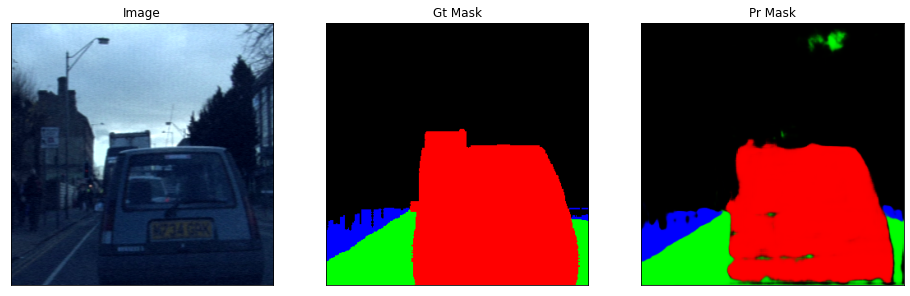

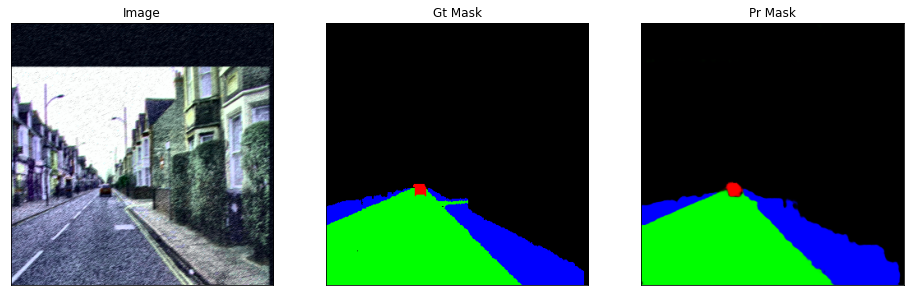

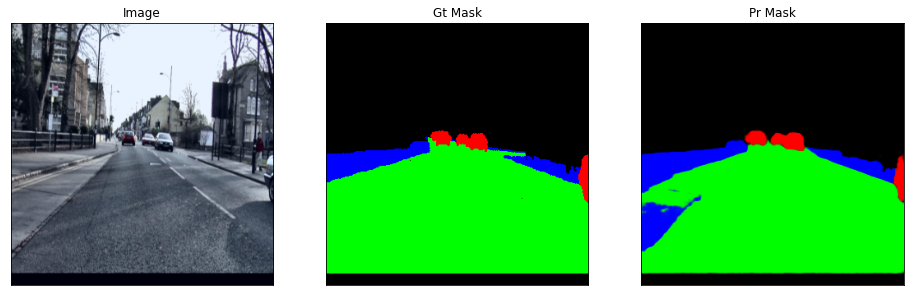

233/233 [==============================] - 16s 70ms/step - loss: 0.3213 - iou_score: 0.7438 - f1-score: 0.8043 - categorical_acc: 0.9653
what - if your <prediction input size> == <training input size>
evaluate shape : (1,320,320,3)
mean iou_score: 0.74383
mean f1-score: 0.80431
mean categorical_acc: 0.96532


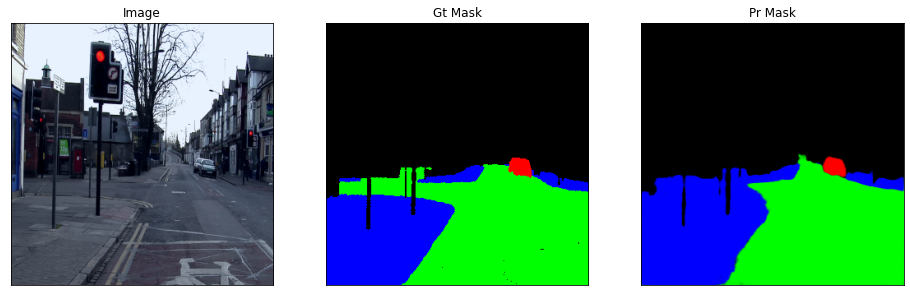

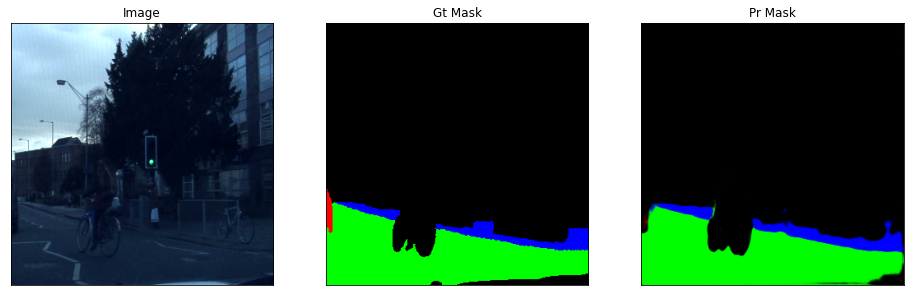

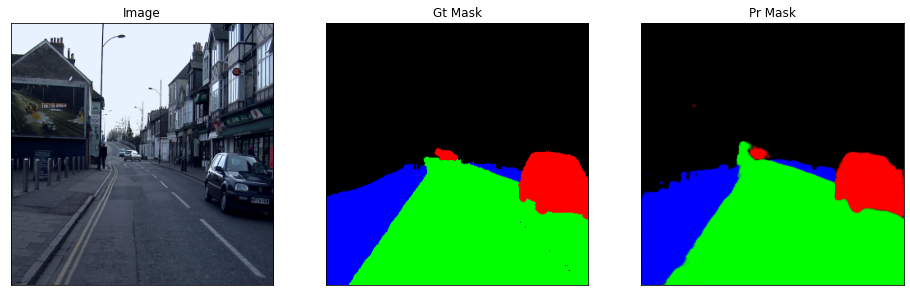

233/233 [==============================] - 18s 74ms/step - loss: 0.2965 - iou_score: 0.7488 - f1-score: 0.8097 - categorical_acc: 0.9619
what - if your <prediction input size> == <validation input size>
evaluate shape : (1,320,448,3)
mean iou_score: 0.74882
mean f1-score: 0.80971
mean categorical_acc: 0.9619


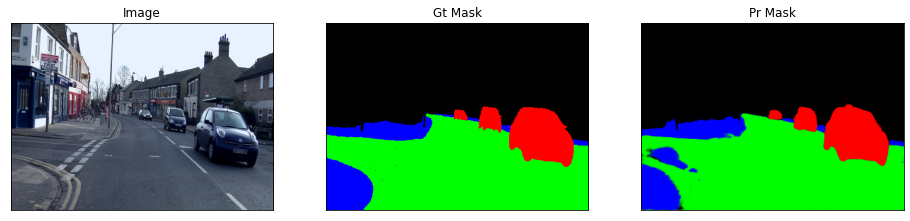

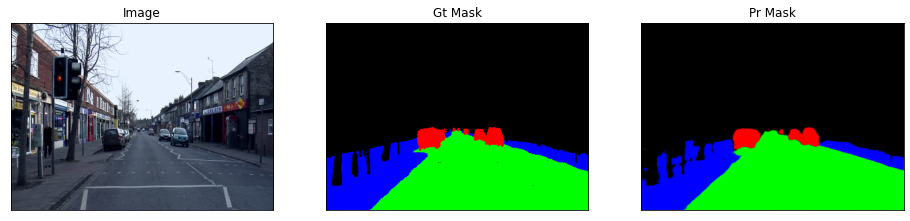

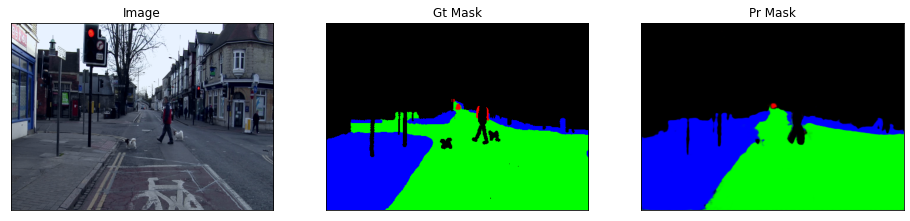

In [35]:
numeric_evaluation(model, preprocess_input)

#### Save the best model

In [36]:
#save with tensorflow savedmodel format
#save without optimizer because optimizer is customized and we'd not use this model for training.
model.save(
    MODELS_DIR_DATASETNAME_MODELINFO, #select model
    include_optimizer=False,
    save_format='tf',
    save_traces=True
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/models/CAMVID/UNET_EFFICIENTNETB7/b8_6c_320_320/assets


## Aihub Pedestrian

For this example we will use Aihub Pedestrian dataset. It is a set of:
- **images and labels** images + segmentation masks
- All images have 1080 pixels height and 1920 pixels width.

<br>

For more inforamtion about dataset visit 
- https://www.aihub.or.kr/aidata/136

<br>

This notebook does not have dataset download link.

### Datasets

In [ ]:
DATASET_DIR_PEDESTRIAN = os.path.join(DATA_DIR, 'aihubsidewalk')
DATASET_TRAIN_TXT_PEDESTRIAN = os.path.join(DATASET_DIR_PEDESTRIAN, 'train.txt')
DATASET_VALID_TXT_PEDESTRIAN = os.path.join(DATASET_DIR_PEDESTRIAN, 'val.txt')
DATASET_TEST_TXT_PEDESTRIAN = os.path.join(DATASET_DIR_PEDESTRIAN, 'test.txt')

%cd {WS}
%ls -al

/content/gdrive/MyDrive/ColabWorkspace
total 24
drwx------ 14 root root 4096 May 27 02:54 albumentations/
drwx------ 15 root root 4096 Jun  4 16:55 efficientnet/
drwx------  2 root root 4096 May 27 02:05 .ipynb_checkpoints/
drwx------ 10 root root 4096 May 25 05:07 paper_implementation_and_testing_tf2/
drwx------ 13 root root 4096 May 26 05:56 segmentation_models/
drwx------  2 root root 4096 Jun  2 02:38 {WEIGHTS_DIR}/


### Hyper Parameters

In [ ]:
# dataset and training info
DATASET_WIDTH = 1920 #@param
DATASET_HEIGHT = 1080 #@param
MODEL_INPUT_WIDTH_FOR_TRAIN = 480 #@param
MODEL_INPUT_HEIGHT_FOR_TRAIN = 320 #@param
RECTANGLE = MODEL_INPUT_WIDTH_FOR_TRAIN == MODEL_INPUT_HEIGHT_FOR_TRAIN 
MODEL_INPUT_WIDTH_FOR_VALID =  480 #@param
MODEL_INPUT_HEIGHT_FOR_VALID = 320 #@param

# model info
ARCHITECTURE = 'unet' #@param ['unet']
BACKBONE = 'mobilenetv2' #@param ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
preprocess_input = sm.get_preprocessing(BACKBONE)
DATASETNAME = 'aihubpedestrian' #@param ['aihubpedestrian']

if ARCHITECTURE == 'unet':
    assert MODEL_INPUT_WIDTH_FOR_TRAIN // 32 == 0, 'unet restricts input image width to multiple of 32.'
    assert MODEL_INPUT_HEIGHT_FOR_TRAIN // 32 == 0, 'unet restricts input image height to multiple of 32.'


# pipeline info
SAVE_WEIGHTS_ONLY = True
INPUT_PIPELINE = 'tf.data' #@param ['tf.keras.Sequence', 'tf.data']

# model hyper parameters
TRAIN_BATCH_SIZE = 32#@param
TRAIN_DATA_LEN = None
TRAIN_DATA_SHAPE = None
TRAIN_STEPS_PER_EPOCH = None
VALID_BATCH_SIZE =  32#@param
VALID_DATA_LEN = None
VALID_STEPS_PER_EPOCH = None
N_EPOCH =  10#@param
START_LR = 0.0001 #@param

NAME_INTERESTED_CLASSES = ["alley_normal", "roadway_normal", "sidewalk_blocks"] #@param
# ['car', 'road', 'pavement', 'pedestrian', 'bicyclist']
N_CLASSES = 1 if len(NAME_INTERESTED_CLASSES) == 1 else (len(NAME_INTERESTED_CLASSES) + 1) # case for binary and multiclass segmentation

def _get_optimizer():
    global START_LR
    _OPTIM = tf.keras.optimizers.Adam(learning_rate=START_LR)
    return _OPTIM
    
def _get_dice_loss():
    global N_CLASSES
    _DICE_LOSS_WEIGHT = [1., 1., 1., 2., 3., 0.2]
    assert len(_DICE_LOSS_WEIGHT) == N_CLASSES
    _DICE_LOSS = sm.losses.DiceLoss(class_weights=np.array(_DICE_LOSS_WEIGHT)) # len(NAME_INTERESTED_CLASSES) + 1
    return _DICE_LOSS

def _get_focal_loss():
    global N_CLASSES
    _FOCAL_LOSS = sm.losses.BinaryFocalLoss() if N_CLASSES == 1 else sm.losses.CategoricalFocalLoss()
    return _FOCAL_LOSS

def _get_metric_iou():
    _IOU = sm.metrics.IOUScore(threshold=0.5)
    return _IOU

def _get_metric_FScore():
    _FScore = sm.metrics.FScore(threshold=0.5)
    return _FScore

def _get_metric_Accuracy():
    global N_CLASSES
    _Accuracy = tf.keras.metrics.BinaryAccuracy(name='binary_acc') if N_CLASSES == 1 else tf.keras.metrics.CategoricalAccuracy(name='categorical_acc')
    return _Accuracy

# Create the model, optimizer and metrics inside the strategy scope, so that the
# variables can be mirrored on each device.
if TRAINING_PARALLEL_STRATEGY is not None:
    with TRAINING_PARALLEL_STRATEGY.scope():
        LOSS_SET = [_get_dice_loss() + _get_focal_loss()]
        METRICS_SET = [_get_metric_iou(), _get_metric_FScore(), _get_metric_Accuracy()]
        OPTIMIZER = _get_optimizer()
else:
    LOSS_SET = [_get_dice_loss() + _get_focal_loss()]
    METRICS_SET = [_get_metric_iou(), _get_metric_FScore(), _get_metric_Accuracy()]
    OPTIMIZER = _get_optimizer()


MODEL_MEMO = 'b{}_{}c_{}_{}'.format(TRAIN_BATCH_SIZE, N_CLASSES, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN)
ADDITIONAL_MEMO = '' #@param {type:"string"}
MODEL_MEMO += ADDITIONAL_MEMO


LOG_DIR_DATASETNAME = os.path.join(LOG_DIR, DATASETNAME.upper())
LOG_DIR_DATASETNAME_MODELINFO = os.path.join(LOG_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
WEIGHTS_DIR_DATASETNAME = os.path.join(WEIGHTS_DIR, DATASETNAME.upper())
WEIGHTS_DIR_DATASETNAME_MODELINFO = os.path.join(WEIGHTS_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)
MODELS_DIR_DATASETNAME = os.path.join(MODELS_DIR, DATASETNAME.upper())
MODELS_DIR_DATASETNAME_MODELINFO = os.path.join(MODELS_DIR_DATASETNAME, '{}_{}'.format(ARCHITECTURE.upper(), BACKBONE.upper()), MODEL_MEMO)

!mkdir -p {LOG_DIR_DATASETNAME_MODELINFO}
%cd {LOG_DIR_DATASETNAME}
%ls

!mkdir -p {WEIGHTS_DIR_DATASETNAME_MODELINFO}
%cd {WEIGHTS_DIR_DATASETNAME}
%ls

!mkdir -p {MODELS_DIR_DATASETNAMET_MODELINFO}
%cd {MODELS_DIR_DATASETNAME}
%ls

"""
LOG_DIR_CAMVID = os.path.join(LOG_DIR, 'CAMVID')
LOG_DIR_CAMVID_UNET_RESNET34 = os.path.join(LOG_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)
LOG_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(LOG_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)

WEIGHTS_DIR_CAMVID = os.path.join(WEIGHTS_DIR, 'CAMVID')
WEIGHTS_DIR_CAMVID_UNET_RESNET34 = os.path.join(WEIGHTS_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)
WEIGHTS_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(WEIGHTS_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)

MODELS_DIR_CAMVID = os.path.join(MODELS_DIR, 'CAMVID')
MODELS_DIR_CAMVID_UNET_RESNET34 = os.path.join(MODELS_DIR_CAMVID, 'UNET_RESNET34', MODEL_MEMO)
MODELS_DIR_CAMVID_UNET_EFFICIENTNETB3 = os.path.join(MODELS_DIR_CAMVID, 'UNET_EFFICIENTNETB3', MODEL_MEMO)

!mkdir -p {LOG_DIR_CAMVID_UNET_RESNET34}
!mkdir -p {LOG_DIR_CAMVID_UNET_EFFICIENTNETB3}

%cd {LOG_DIR_CAMVID}
%ls

!mkdir -p {WEIGHTS_DIR_CAMVID_UNET_RESNET34}
!mkdir -p {WEIGHTS_DIR_CAMVID_UNET_EFFICIENTNETB3}

%cd {WEIGHTS_DIR_CAMVID}
%ls

!mkdir -p {MODELS_DIR_CAMVID_UNET_RESNET34}
!mkdir -p {MODELS_DIR_CAMVID_UNET_EFFICIENTNETB3}

%cd {MODELS_DIR_CAMVID}
%ls
"""

/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/tboard/PEDESTRIAN
UNET_EFFICIENTNETB3/  UNET_RESNET34/
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/weights/PEDESTRIAN
UNET_EFFICIENTNETB3/  UNET_RESNET34/
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2/models/PEDESTRIAN
UNET_EFFICIENTNETB3/  UNET_RESNET34/


### [Choice] Data Loader (tf.keras.Sequence)

In [278]:
class AihubPedestrianDataset(SegmentationDataset):
    """Aihub Pedestrian Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        name_interested_classes (list): values of interested classes names
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """

    train_id_to_label_li = {}
    train_id_to_label_li[0] = ["background"] # background, car, man, building, sky, ... and so on.
    train_id_to_label_li[1] = ["alley_normal"] # can go : man / vehicle / bycicle
    train_id_to_label_li[2] = ["alley_crosswalk",] # can go : man / vehicle / bycicle
    train_id_to_label_li[3] = ["alley_speed_bump",] # can go : man / vehicle / bycicle
    train_id_to_label_li[4] = ["roadway_crosswalk",] # can go : man / bycicle / vehicle
    train_id_to_label_li[5] = ["roadway_normal",] # can go : vehicle
    train_id_to_label_li[6] = ["bike_lane_normal"] # can go : bycicle
    train_id_to_label_li[7] = ["caution_zone_stairs",] # scooter cannot go. (not recommend)
    train_id_to_label_li[8] = ["alley_damaged",] # scooter cannot go. (not recommend)
    train_id_to_label_li[9] = ["caution_zone_grating",] # scooter cannot go. (not recommend)
    train_id_to_label_li[10] = ["caution_zone_manhole",] # scooter cannot go. (not recommend)
    train_id_to_label_li[11] = ["caution_zone_tree_zone",] # scooter cannot go. (not recommend)
    train_id_to_label_li[12] = ["caution_zone_repair_zone",] # scooter cannot go. (not recommend)
    train_id_to_label_li[13] = ["sidewalk_damaged"] # scooter cannot go. (not recommend)
    train_id_to_label_li[14] = ["braille_guide_blocks_normal",] # scooter cannot go. (not recommend)
    train_id_to_label_li[15] = ["braille_guide_blocks_damaged", ] # scooter cannot go. (not recommend)
    train_id_to_label_li[16] = ["sidewalk_blocks",] # can go : man
    train_id_to_label_li[17] = ["sidewalk_cement",]  # can go : man
    train_id_to_label_li[18] = ["sidewalk_urethane",] # can go : man
    train_id_to_label_li[19] = ["sidewalk_asphalt",] # can go : man
    train_id_to_label_li[20] = ["sidewalk_soil_stone",] # can go : man
    train_id_to_label_li[21] = ["sidewalk_other"] # can go : man
    train_id_to_rgb = {
        0: (0,     0,    0),   # 0=noclass
        1: (0,   255,   255),   # 1=can go : alley
        2: (40,   255-40,  255),   # 1=can go : alley
        3: (80,   255-80,  255),   # 1=can go : alley
        4: (120,   255-120,  255),   # 1=can go : alley
        5: (0,      0,  255),   # 5=can go : road
        6: (0,    128,  128),   # 2=can go : bike road
        7: (255,  40,    0),   # 3=can't go : damaged/stair road
        8: (255,  80,    0),   # 3=can't go : damaged/stair road
        9: (255,  120,    0),   # 3=can't go : damaged/stair road
        10:(255,  180,    40),   # 3=can't go : damaged/stair road
        11:(255,  220,    80),   # 3=can't go : damaged/stair road
        12:(255,  140,    120),   # 3=can't go : damaged/stair road
        13:(255,  128,    160),   # 3=can't go : damaged/stair road
        14:(255,  128,    180),   # 3=can't go : damaged/stair road
        15:(255,  128,    220),   # 3=can't go : damaged/stair road
        16:(0,    255,    0),   # 6=can go : sidewalk
        17:(0,   255,    160),   # 6=can go : sidewalk
        18:(40,   255,    120),   # 6=can go : sidewalk    
        19:(80,   255,    80),   # 6=can go : sidewalk
        20:(120,   255,    40),   # 6=can go : sidewalk
        21:(160,  255,    0),   # 6=can go : sidewalk
        }

    CLASSES = [i[0] for i in list(train_id_to_label_li.values())]
    COLORMAP = train_id_to_rgb

    def fill_data(self, im_mask_txt_path):
        # self.images_fps (list): path to images folder
        # self.masks_fps (list): path to segmentation masks folder
        self.images_fps = []
        self.masks_fps = []
        assert os.path.exists(im_mask_txt_path), '{:s} not exist'.format(im_mask_txt_path)
        with open(im_mask_txt_path, 'r') as file:
            num_lines = sum(1 for i in file)
            file.seek(0)
            with tqdm(total=num_lines, position=1) as pbar:
                for line in file:
                    line_info = line.rstrip('\r').rstrip('\n').strip(' ').split()
                    src_image_path = line_info[0]
                    label_image_path = line_info[1]
                    assert os.path.exists(src_image_path), '{:s} not exist'.format(src_image_path)
                    assert os.path.exists(label_image_path), '{:s} not exist'.format(label_image_path)
                    self.images_fps.append(src_image_path)
                    self.masks_fps.append(label_image_path)
                    pbar.update(1)

    def __init__(self, im_mask_txt_path, name_interested_classes=None, augmentation=None, preprocessing=None):
        # convert str names to class values on masks
        class_ids = [self.CLASSES.index(cls.lower()) for cls in name_interested_classes]
        
        super(AihubPedestrianDataset, self).__init__(class_ids=class_ids, augmentation=augmentation, preprocessing=preprocessing)
        self.fill_data(im_mask_txt_path)
        self.train_id_to_rgb = self.COLORMAP

# Dataset for train images
XY_train = AihubPedestrianDataset(
    DATASET_TRAIN_TXT_PEDESTRIAN, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

# Dataset for validation images
XY_valid = AihubPedestrianDataset(
    DATASET_VALID_TXT_PEDESTRIAN, 
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

# Dataset for test images
XY_test = AihubPedestrianDataset(
    DATASET_TEST_TXT_PEDESTRIAN,
    name_interested_classes=NAME_INTERESTED_CLASSES, 
    augmentation=None,
    preprocessing=None,
)

NameError: ignored

### [Choice] Data Loader (tf.data)

### Data Augmentation

In [ ]:
def round_and_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

class RoundAndClipZeroOrOneOnMask(A.core.transforms_interface.DualTransform):
    def apply(self, img, **params): # target : img
        return img
    def apply_to_mask(self, img, **params): # target : mask
        return round_and_clip_0_1(img, **params) # mask value should be zero or one.

class PretrainedSpecificPreprocessing(A.core.transforms_interface.DualTransform):
    def __init__(self, fn):
        """
        Args:
            fn (callbale): data normalization function (can be specific for each pretrained neural network)
        """
        super().__init__(self)
        self.fn = fn
    def apply(self, img, **params): # target : img
        return self.fn(img)
    def apply_to_mask(self, img, **params): # target : mask
        return img

# define heavy augmentations
def get_training_augmentation(
    dataset_w=None, 
    dataset_h=None,
    model_input_w_for_train=None,
    model_input_h_for_train=None,
    rectangle=RECTANGLE
    ):
    assert dataset_w is not None
    assert dataset_h is not None
    assert model_input_w_for_train is not None
    assert model_input_h_for_train is not None

    shorter_side = dataset_w if dataset_w < dataset_h else dataset_h
    longer_side = dataset_w if dataset_w > dataset_h else dataset_h
    padding_percent = 10
    pad_h = int(model_input_h_for_train / 100 * padding_percent)
    pad_w = int(model_input_w_for_train / 100 * padding_percent)

    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=(-0.5, -0.2), rotate_limit=0, shift_limit=0.1, p=1, border_mode=4), # difference !!!

        A.PadIfNeeded(min_height=longer_side, min_width=longer_side, always_apply=True, border_mode=0) \
          if rectangle else A.PadIfNeeded(min_height=model_input_h_for_train+pad_h, min_width=model_input_w_for_train+pad_w, always_apply=True, border_mode=0),
        
        A.RandomCrop(height=model_input_h_for_train, width=model_input_w_for_train, always_apply=True) \
          if rectangle else A.RandomCrop(height=model_input_h_for_train, width=model_input_w_for_train, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        # A.Perspective(p=0.5, always_apply=True), # This method not support yet. (2021.05.28) try later.
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        RoundAndClipZeroOrOneOnMask()
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(
    dataset_w=None, 
    dataset_h=None,
    model_input_w_for_valid=None,
    model_input_h_for_valid=None
    ):
    assert dataset_w is not None
    assert dataset_h is not None
    #assert model_input_w_for_valid is not None
    #assert model_input_h_for_valid is not None

    """Add paddings to make image shape divisible by 32""" #FIXME
    test_transform = [
        A.ShiftScaleRotate(scale_limit=(-0.5, -0.2), rotate_limit=0, shift_limit=0.1, p=1, border_mode=4),
        A.PadIfNeeded(min_height=dataset_h, min_width=dataset_w)
    ]

    if (model_input_w_for_valid is not None) and (model_input_h_for_valid is not None):
        test_transform.append(
            A.RandomCrop(height=model_input_h_for_valid, 
                         width=model_input_w_for_valid, 
                         always_apply=True))
        #assert model_input_w_for_valid//32 == 0, 'For EfficientNet'
        #assert model_input_h_for_valid//32 == 0, 'For EfficientNet'
    else:
        pass
        #assert dataset_w//32 == 0, 'For EfficientNet'
        #assert dataset_h//32 == 0, 'For EfficientNet'
        
    return A.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        PretrainedSpecificPreprocessing(preprocessing_fn)
    ]
    return A.Compose(_transform)

### EDA

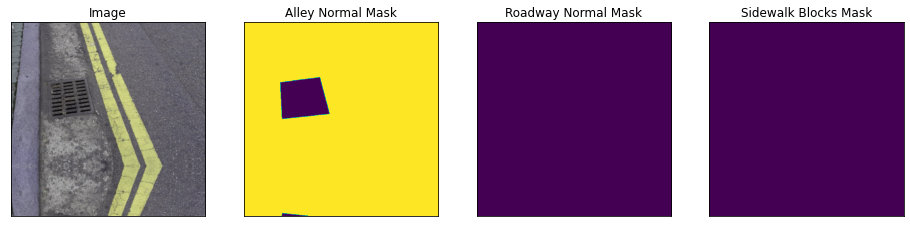

In [ ]:
XY_train.augmentation = get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, rectangle=RECTANGLE)
image, mask = XY_train[5] # get some sample
DataPostProcessTools.visualize(
    image=image,
    alley_normal_mask=mask[..., 0].squeeze(),
    roadway_normal_mask=mask[..., 1].squeeze(),
    sidewalk_blocks_mask=mask[..., 2].squeeze(),
)

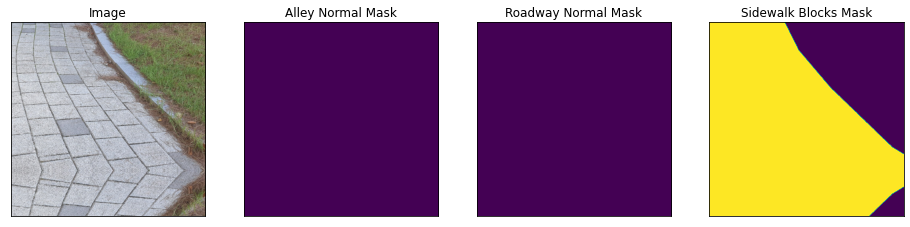

In [ ]:
XY_valid.augmentation = get_validation_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN)
image, mask = XY_valid[5] # get some sample
DataPostProcessTools.visualize(
    image=image,
    alley_normal_mask=mask[..., 0].squeeze(),
    roadway_normal_mask=mask[..., 1].squeeze(),
    sidewalk_blocks_mask=mask[..., 2].squeeze(),
)

### Run UNet-BACKBONE

#### Train

In [ ]:
!rm -r {LOG_DIR_DATASETNAME_MODELINFO} #select model
tf.keras.backend.clear_session()

XY_train.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
XY_train.augmentation   = get_training_augmentation(dataset_w=DATASET_WIDTH, 
                                                    dataset_h=DATASET_HEIGHT,
                                                    model_input_w_for_train=MODEL_INPUT_WIDTH_FOR_TRAIN,
                                                    model_input_h_for_train=MODEL_INPUT_HEIGHT_FOR_TRAIN,
                                                    rectangle=RECTANGLE)

XY_valid.preprocessing  = get_preprocessing(preprocess_input) # 사전학습 모델에 맞는 전처리방법을 선택
XY_valid.augmentation   = get_validation_augmentation(dataset_w=DATASET_WIDTH,
                                                      dataset_h=DATASET_HEIGHT,
                                                      model_input_w_for_valid=MODEL_INPUT_WIDTH_FOR_VALID,
                                                      model_input_h_for_valid=MODEL_INPUT_HEIGHT_FOR_VALID)

train_dataloader = DataLoader(XY_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
assert train_dataloader[0][0].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, 3)
assert train_dataloader[0][1].shape == (TRAIN_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_TRAIN, MODEL_INPUT_WIDTH_FOR_TRAIN, N_CLASSES)
valid_dataloader = DataLoader(XY_valid, batch_size=VALID_BATCH_SIZE, shuffle=True)
assert valid_dataloader[0][0].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, 3)
assert valid_dataloader[0][1].shape == (VALID_BATCH_SIZE, MODEL_INPUT_HEIGHT_FOR_VALID, MODEL_INPUT_WIDTH_FOR_VALID, N_CLASSES)

if TRAINING_PARALLEL_STRATEGY is None: 
    #tf.summary function unstable. Do not use this function when you run on TPU
    #later, wrap with @tf.function instead. See tf.summary documentation.
    image_writer = tf.summary.create_file_writer(os.path.join(LOG_DIR_DATASETNAME_MODELINFO, 'image_ex')) #select model
    mask_writer = tf.summary.create_file_writer(os.path.join(LOG_DIR_DATASETNAME_MODELINFO, 'mask_ex')) #select model
    with image_writer.as_default():
        images = train_dataloader[0][0]
        tf.summary.image("One batch image", images, max_outputs=TRAIN_BATCH_SIZE, step=0)
    if N_CLASSES == 3: 
        #FIXME!
        with mask_writer.as_default():
            mask = train_dataloader[0][1]
            tf.summary.image("One batch mask", mask, max_outputs=TRAIN_BATCH_SIZE, step=0)

callback_tboard = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR_DATASETNAME_MODELINFO, #select model
    histogram_freq=1, write_graph=False, 
    #write_graph=True option unstable. Do not use option especially when you run on TPU
    write_images=True, update_freq='batch', profile_batch=1,
    #profile_batch does not work on tf 2.5 or tensorboard latest version. Maybe we should wait for bugfix :)
    embeddings_freq=0, embeddings_metadata=None
)
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(WEIGHTS_DIR_DATASETNAME_MODELINFO,'epoch-{epoch:02d}-valloss-{val_loss:.2f}'), #select model
    save_weights_only=True, save_best_only=True, mode='min' #save weights True
)
callback_lrtuner = tf.keras.callbacks.ReduceLROnPlateau()

if TRAINING_PARALLEL_STRATEGY is not None:
    with TRAINING_PARALLEL_STRATEGY.scope():
        model = sm.Unet(BACKBONE, 
                        classes=N_CLASSES, 
                        activation='softmax',
                        encoder_weights='imagenet',
                        encoder_freeze=False)
        model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)
else:
    model = sm.Unet(BACKBONE, 
                    classes=N_CLASSES, 
                    activation='softmax',
                    encoder_weights='imagenet',
                    encoder_freeze=False)
    model.compile(OPTIMIZER, LOSS_SET, METRICS_SET)
    f = os.path.join(MODEL_PLOT_DIR, '{}-{}.jpg'.format(ARCHITECTURE, BACKBONE)) #select model
    tf.keras.utils.plot_model(model, to_file=f, show_shapes=True, show_layer_names=True)
model.summary()

TRAIN_STEPS_PER_EPOCH = len(train_dataloader)
VALID_STEPS_PER_EPOCH = len(valid_dataloader)

model.fit(train_dataloader,
          validation_data=valid_dataloader,
          steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
          validation_steps=VALID_STEPS_PER_EPOCH,
          epochs=N_EPOCH,
          callbacks=[callback_tboard, callback_bestmodel, callback_lrtuner],
          verbose=1
          )

# Debug and trial Area

### abstract class and implementation

In [ ]:
import abc
class Temp(abc.ABC):
    def __init__(self):
        print('Temp init')
        self.a = 1
        self.b = 2
        self.implementme_a = None
        self.implementme_b = None
        self.implementthis()

    def temp(self):
        return None

    @abc.abstractmethod
    def implementthis(self):
        print('abstract')
        pass

# t = Temp()
# t.temp(1,2,3, hello='world')
# t.implementthis()

class ImplementTemp(Temp):
    def __init__(self):
        print('ImplementTemp init')
        self.c = 3
        self.d = 4

        self.hello = ['hello', 'hi', 'fine']
        self.bye = ['good', 'afternoon']

        super(ImplementTemp, self).__init__()
    
    def implementthis(self):
        print(self.hello)
        print(self.bye)
        print('implementthis called')

it = ImplementTemp()

ImplementTemp init
Temp init
['hello', 'hi', 'fine']
['good', 'afternoon']
implementthis called


### args and kwargs

In [ ]:
def temp_2(a, b, c=None, d=None):
    print(a, b, c, d)

def temp(*args, **kwargs):
    temp_2(*args, **kwargs)
    temp_2(args, kwargs)
    
temp('a','b', c=3, d=4)

a b 3 4
('a', 'b') {'c': 3, 'd': 4} None None


### dictionary slicing

In [ ]:
li = [1,2,3]
[i for i in [1,2,]]

[1, 2]

In [ ]:
dic = {'1':2, '2':4}
print(dic)
for i, j in dic.items():
    print(i,j)

{'1': 2, '2': 4}
1 2
2 4


### Keras Model and Input tensor

In [130]:
tf.keras.backend.clear_session()
mobile = tf.keras.applications.MobileNetV2(
    input_shape=None, alpha=1.0, include_top=True, weights=None,
    input_tensor=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)
mobile.summary()

newinput = tf.keras.Input(shape=(558,558,3))
i = mobile.input
o = mobile.output
newoutput = model(newinput)
mobile = tf.keras.Model(inputs=i, outputs=o, name='hello')
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

NameError: ignored

### tf.data

In [509]:
tf_dataset_debug_aug = CamVidDatasetTF(DATASET_TRAIN_X_DIR_CAMVID, DATASET_TRAIN_Y_DIR_CAMVID, 
                                       name_interested_classes=['car', 'sky'], 
                                       augmentation=get_training_augmentation(DATASET_WIDTH, DATASET_HEIGHT, MODEL_INPUT_WIDTH_FOR_TRAIN, MODEL_INPUT_HEIGHT_FOR_TRAIN, rectangle=RECTANGLE))
tf_dataset_debug_aug.mode = 'tf.data.Dataset'
d_1 = tf_dataset_debug_aug.get_tf_dataset()
for i in d_1.take(3):
    print(i[0].shape, i[1].shape)

print('\n---\n')
d_2 = data_loader_tf(tf_dataset_debug_aug.get_tf_dataset(), 1)
for j in d_2.take(3):
    print(j[0].shape, j[1].shape)

Retracing!
Tensor("Identity:0", shape=(None, None, 3), dtype=uint8)
Tensor("EagerPyFunc:0", dtype=uint8, device=/job:localhost/replica:0/task:0)
(360, 480, 3) (360, 480, 3)
(360, 480, 3) (360, 480, 3)
(360, 480, 3) (360, 480, 3)

---

Retracing!
Tensor("Identity:0", shape=(None, None, 3), dtype=uint8)
Tensor("EagerPyFunc:0", dtype=uint8, device=/job:localhost/replica:0/task:0)
(1, 360, 480, 3) (1, 360, 480, 3)
(1, 360, 480, 3) (1, 360, 480, 3)
(1, 360, 480, 3) (1, 360, 480, 3)
